In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
import scipy
import numpy as np
from scipy import signal 
import pandas as pd
import matplotlib.pyplot as plt
sample_rate=256


In [ ]:
def Notch_filter(sig_data):

  fr=50
  fs=sample_rate
  Q=10
  b,a = signal.iirnotch(fr,Q,fs)
  filted_data=scipy.signal.filtfilt(b,a,sig_data)
   
  b, a = signal.butter(8, [0.004,0.86], 'bandpass')   #配置滤波器 8 表示滤波器的阶数
  filtedData = signal.filtfilt(b, a, filted_data)  #data为要过滤的信号

  return filtedData 

In [ ]:
def FFT_ham(sig_data):
  
  fs=256
  N=1280
  
  hamming_win=signal.hamming(N)
  sig_win=sig_data*hamming_win

  sig_fft=np.fft.fft(sig_win)

  f=np.fft.fftfreq(N, 1/fs)

  
  #plt.plot(f, np.abs(sig_fft))
  #plt.xlabel('Freq')
  #plt.ylabel('Magnitude')
  #plt.show()
  return sig_fft, f

In [ ]:
# Delta 0.5-4
# theta 4-8
# alpha 7.5-13
# beta 13-30
# gamma 30-44
def split(eeg_power,seg_data):
  eeg=eeg_power[:640]
  
  eeg_delta=eeg[int(0.5/128*640):int(4/128*640)]
  eeg_theta=eeg[int(4/128*640):int(8/128*640)]
  eeg_alpha=eeg[int(7.5/128*640):int(13/128*640)]
  eeg_beta=eeg[int(13/128*640):int(30/128*640)]
  eeg_gamma=eeg[int(30/128*640):int(44/128*640)]
  eeg_fi=eeg[int(0.85/128*640):int(110/128*640)]

  eeg_delta_csv=np.hstack((eeg_delta,np.zeros(1280-eeg_delta.shape[0])))
  eeg_theta_csv=np.hstack((eeg_theta,np.zeros(1280-eeg_theta.shape[0])))
  eeg_alpha_csv=np.hstack((eeg_alpha,np.zeros(1280-eeg_alpha.shape[0])))
  eeg_beta_csv=np.hstack((eeg_beta,np.zeros(1280-eeg_beta.shape[0])))
  eeg_gamma_csv=np.hstack((eeg_gamma,np.zeros(1280-eeg_gamma.shape[0])))
  eeg_fi_csv=np.hstack((eeg_fi,np.zeros(1280-eeg_fi.shape[0])))
  #print(eeg_delta_csv.shape)
  #print(eeg_theta_csv.shape)
  #print(eeg_alpha_csv.shape)
  #print(eeg_beta_csv.shape)
  #print(eeg_gamma_csv.shape)
  seg_data['EEG_delta']=eeg_delta_csv
  seg_data['EEG_theta']=eeg_theta_csv
  seg_data['EEG_alpha']=eeg_alpha_csv
  seg_data['EEG_beta']=eeg_beta_csv
  seg_data['EEG_gamma']=eeg_gamma_csv
  seg_data['EEG_fi']=eeg_fi_csv
  return eeg_delta, eeg_theta, eeg_alpha, eeg_beta, eeg_gamma, eeg_fi, seg_data


In [ ]:
def get_channel_mean(eeg_power,seg_data,file):
  
  eeg_delta, eeg_theta, eeg_alpha, eeg_beta, eeg_gamma, eeg_fi,seg_data =split(eeg_power,seg_data)
  delta=np.mean(eeg_delta)
  theta=np.mean(eeg_theta)
  alpha=np.mean(eeg_alpha)
  beta=np.mean(eeg_beta)
  gamma=np.mean(eeg_gamma)
  fi=np.mean(eeg_fi)
  #cal_data=pd.DataFrame({file:{'delta':[delta],'theta':[theta],'alpha':[alpha],'beta':[beta],'gamma':[gamma],'fi':[fi]}})
  #print(cal_data)

  return delta, theta, alpha, beta, gamma, fi, seg_data



In [ ]:
def Sp_cal(delta, theta, alpha, beta, gamma, fi):
  Sp1=delta
  Sp2=theta
  Sp3=alpha
  Sp4=theta/beta
  Sp5=theta/alpha
  Sp6=theta/fi
  Sp7=theta/alpha+beta+gamma
  Sp8=delta/alpha+beta+gamma
  Sp9=delta/alpha
  Sp10=delta/fi
  Sp11=delta/beta
  Sp12=delta/theta
  Sp13=theta/alpha+beta+theta 
  Sp14=alpha/theta+alpha+beta
  Sp15=beta/theta+alpha+beta

  cal_data=pd.DataFrame({'Sp1':{file:[Sp1]},'Sp2':{file:[Sp2]},
             'Sp3':{file:[Sp3]},'Sp4':{file:[Sp4]},'Sp5':{file:[Sp5]},'Sp6':{file:[Sp6]},
             'Sp7':{file:[Sp7]},'Sp8':{file:[Sp8]},'Sp9':{file:[Sp9]},'Sp10':{file:[Sp10]},
             'Sp11':{file:[Sp11]},'Sp12':{file:[Sp12]},'Sp13':{file:[Sp13]},'Sp14':{file:[Sp14]},'Sp15':{file:[Sp15]}})
  res=[Sp1,Sp2,Sp3,Sp4,Sp5,Sp6,Sp7,Sp8,Sp9,Sp10,Sp11,Sp12,Sp13,Sp14,Sp15]
   #cal_data=pd.DataFrame({'delta':{file:[delta]},'theta':{file:[theta]},'alpha':[alpha],'beta':[beta],'gamma':[gamma],'fi':[fi],
     #           'Sp1':[Sp1],'Sp2':[Sp2],'Sp3':[Sp3],'Sp4':[Sp4],'Sp5':[Sp5],'Sp6':[Sp6],'Sp7':[Sp7],'Sp8':[Sp8],
     #           'Sp9':[Sp9],'Sp10':[Sp10],'Sp11':[Sp11],'Sp12':[Sp12],'Sp13':[Sp13],'Sp14':[Sp14],'Sp15':[Sp15]})
 # print(cal_data)

  return cal_data,res

In [ ]:
num=['04','06','08','09','11','12']
Sp_wk=[]
KSS=[]
for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
   usr_seg=os.listdir(usr_seg_folder+'_wk')
   #x=[]
   #KSS=[]
   for folder in usr_seg:
     if(folder[-4]=='.'):
     #  print(0)
        continue
     data_folder=usr_seg_folder+'_wk'+'/'+folder
     data_file=os.listdir(data_folder)
     if (os.path.exists(data_folder+'/.ipynb_checkpoints')):
       data_file.remove('.ipynb_checkpoints')
     #print(data_file)
     out_feature=data_folder+".csv"#,"w")
     feature=pd.DataFrame()
     for file in data_file:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]

       seg_data=pd.read_csv(data_folder+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       feature=pd.concat([feature,cal_data], axis=0)
       
       Sp_wk.append(res)
       KSS.append(1)
print(Sp_wk)
print(KSS)
     #feature.to_csv(out_feature)


[[2.7617735325447666e-07, 2.5516440099147e-08, 4.061627323033822e-08, 1.0563199340198721, 0.6282319393126291, 1.1649315422412974, 0.6282320140585099, 6.799672503780721, 6.799672429034841, 12.608644027487685, 11.433085588506687, 10.823506421011649, 0.6282319889850463, 1.59176886451544, 0.9466829472910493], [1.740562833672876e-06, 4.867244288955962e-08, 2.7418051875944188e-08, 3.4057487091773337, 1.7751969800693035, 1.334244074995972, 1.7751970098032162, 63.482367104835845, 63.48236707510193, 47.713562544122524, 121.79211217062202, 35.7607453076129, 1.7751970430330073, 0.5633178093865424, 0.29362123498917514], [9.688766563511315e-07, 4.378551300168802e-08, 2.012038957461437e-08, 4.378847431054007, 2.1761762037118615, 2.6912281015918693, 2.1761762246706935, 48.15397103420157, 48.15397101324273, 59.550931479277416, 96.89421835728609, 22.12779044780815, 2.176176257496698, 0.45952164344050933, 0.22837062666257935], [7.443731375880551e-07, 2.9226912884599645e-08, 2.0156202559662806e-08, 2.856

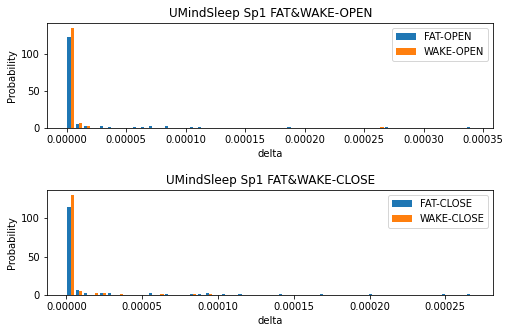

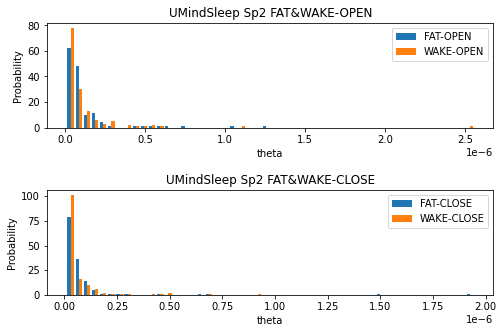

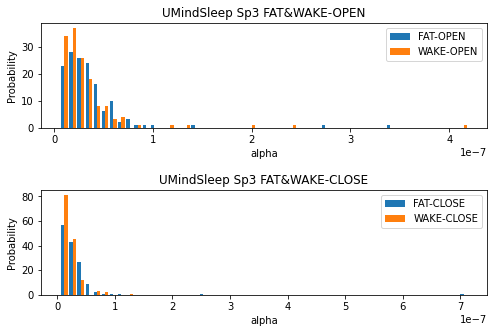

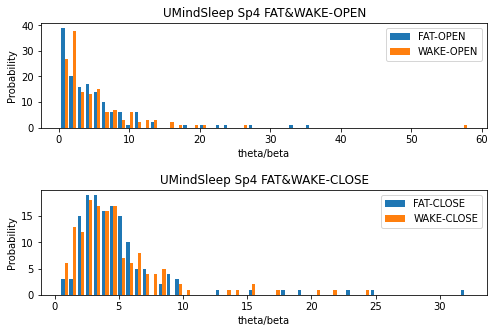

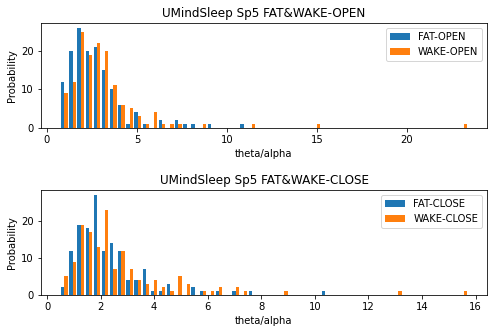

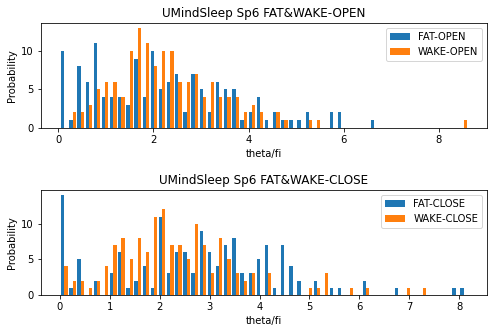

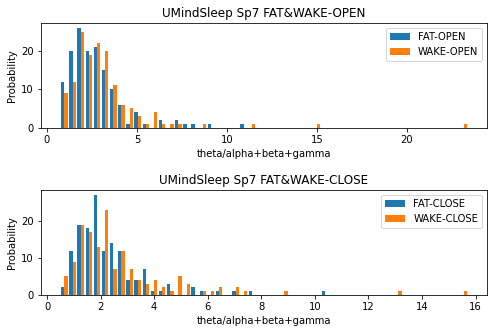

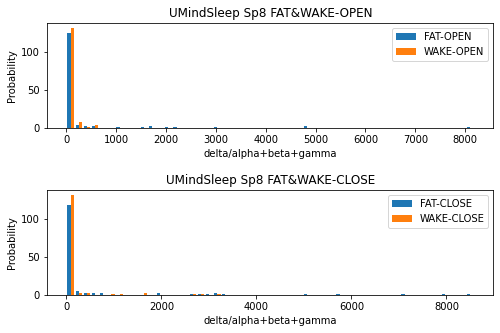

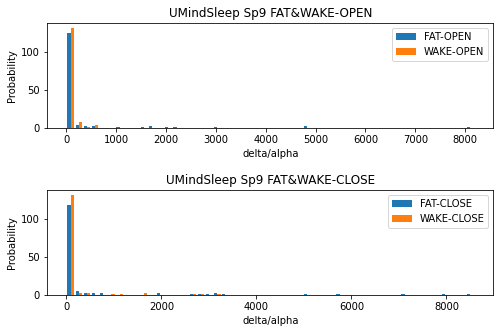

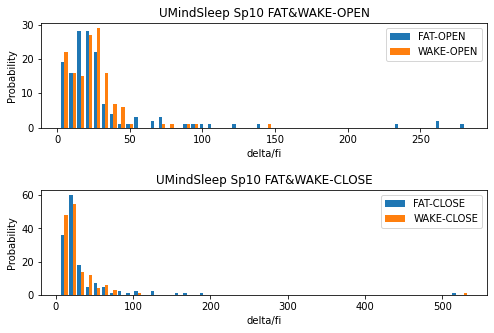

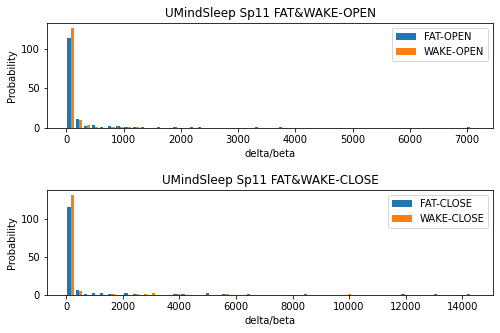

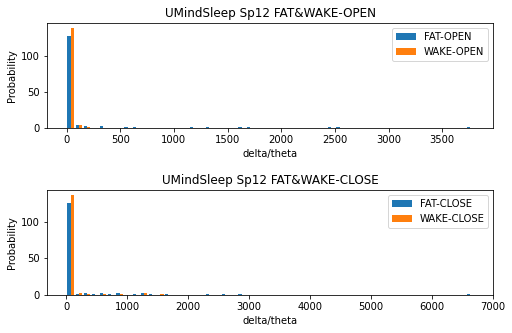

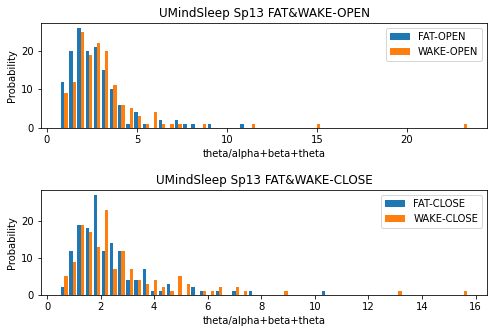

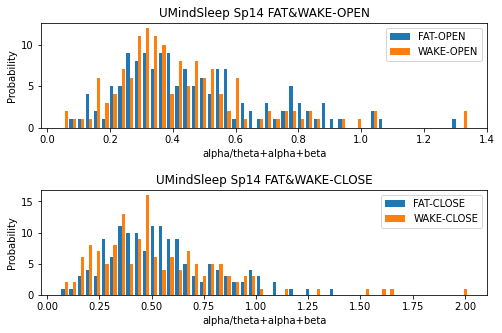

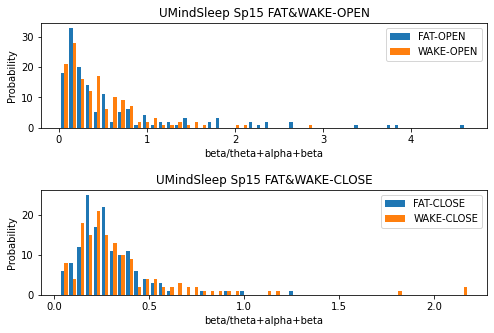

In [ ]:
SLO=np.transpose(np.array(SpSLO))
SLC=np.transpose(np.array(SpSLC))
WKO=np.transpose(np.array(SpWKO))
WKC=np.transpose(np.array(SpWKC))
xlabel=['delta','theta','alpha','theta/beta','theta/alpha','theta/fi','theta/alpha+beta+gamma',
        'delta/alpha+beta+gamma','delta/alpha','delta/fi','delta/beta','delta/theta','theta/alpha+beta+theta',
        'alpha/theta+alpha+beta','beta/theta+alpha+beta']
for i in range(0,15):
  fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,5))
  
 
 # plt.subplot(121)
  #plt.hist(SPWK[i], 432)
  #plt.subplot(122)
  #plt.hist(SPSL[i], 432)
  ax1.set_title("UMindSleep Sp"+str(i+1)+" FAT&WAKE-OPEN")
  ax1.hist([SLO[i],WKO[i]],50,histtype='bar',label=['FAT-OPEN','WAKE-OPEN'])
  ax1.set_ylabel("Probability")
  ax1.set_xlabel(xlabel[i])
 # ax1.hist(WKO[i],100,label='WAKE-OPEN')
  ax1.legend()
  ax2.set_title("UMindSleep Sp"+str(i+1)+" FAT&WAKE-CLOSE")
  ax2.hist([SLC[i],WKC[i]],50,histtype='bar',label=['FAT-CLOSE','WAKE-CLOSE'])
  ax2.set_ylabel("Probability")
  ax2.set_xlabel(xlabel[i])
  #ax2.hist(WKC[i],100,label='WAKE-CLOSE')
  #print(SP_trans[i])
  ax2.legend()
  plt.subplots_adjust(hspace=0.6)
  print()
  print()
  plt.show()


In [ ]:

##################################################plot
num=['04','06','08','09','11','12']
wkaverageclose=np.zeros(1280)
wkaverageopen=np.zeros(1280)
for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
   usr_seg=os.listdir(usr_seg_folder+'_wk')
   #x=[]
   #KSS=[]
   for folder in usr_seg:
     if(folder[-4]=='.'):
     #  print(0)
        continue
     data_folder=usr_seg_folder+'_wk'+'/'+folder
     data_file=os.listdir(data_folder)
     if (os.path.exists(data_folder+'/.ipynb_checkpoints')):
       data_file.remove('.ipynb_checkpoints')
     #print(data_file)
     out_feature=data_folder+".csv"#,"w")
     i=0
     feature=pd.DataFrame()
     for file in data_file:
       
       seg_data=pd.read_csv(data_folder+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       

       if(file==str('fat_'+ID+'_wk_close2_'+str(i)+'.csv')):
         wkaverageclose=wkaverageclose+seg_datanp
       #   print(1)
       else:
         wkaverageopen=wkaverageopen+seg_datanp
      # print(data_folder+'/'+'fat_'+ID+'_wk_close2_'+str(i)+'.csv')
       i=i+1
      
wkaverageopen=wkaverageopen/(24*2*6)
      
wkaverageclose=wkaverageclose/(24*2*6)



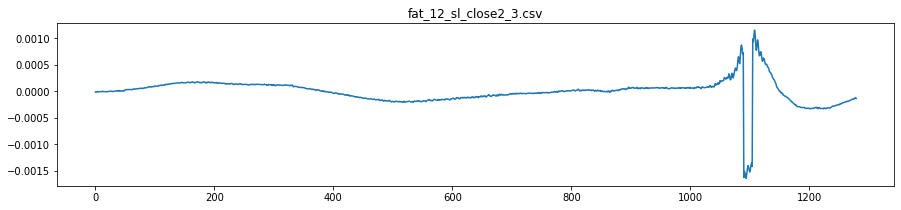

In [ ]:

##################################################plot
num=['04','06','08','09','11','12']
slaverageclose=np.zeros(1280)
slaverageopen=np.zeros(1280)

f=np.zeros(22)
for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
   usr_seg=os.listdir(usr_seg_folder+'_sl')
   #x=[]
   #KSS=[]
   for folder in usr_seg:
     if(folder[-4]=='.'):
     #  print(0)
        continue
     data_folder=usr_seg_folder+'_sl'+'/'+folder
     data_file=os.listdir(data_folder)
     if (os.path.exists(data_folder+'/.ipynb_checkpoints')):
       data_file.remove('.ipynb_checkpoints')
     
     #print(data_file)
     out_feature=data_folder+".csv"#,"w")
     i=0
     feature=pd.DataFrame()
     for file in data_file:
       
       seg_data=pd.read_csv(data_folder+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       if(file=="fat_12_sl_close2_3.csv"):
         
         plt.figure(figsize=(15,3))
         plt.title(file)
         plt.plot(seg_datanp)
         i=i+1
         continue
       #seg_datanp=Notch_filter(seg_datanp)
       #sig_fft,freq_fft=FFT_ham(seg_datanp)
       if(file==str('fat_'+ID+'_sl_close2_'+str(i)+'.csv')):
         slaverageclose=slaverageclose+seg_datanp
         #np.savetxt(seg_datanp[1088:1110])
         #f=np.vstack((f,seg_datanp[1088:1110]))
         #plt.title(file)
         #plt.figure(figsize=(15,3))
         #plt.plot(seg_datanp)
       #   print(1)
       else:
         slaverageopen=slaverageopen+seg_datanp
      # print(data_folder+'/'+'fat_'+ID+'_wk_close2_'+str(i)+'.csv')
       i=i+1
      
slaverageopen=slaverageopen/(24*2*6)
      
slaverageclose=slaverageclose/(24*2*6)



In [ ]:
np.savetxt("/content/drive/MyDrive/UMindSleep/text1.txt",f)

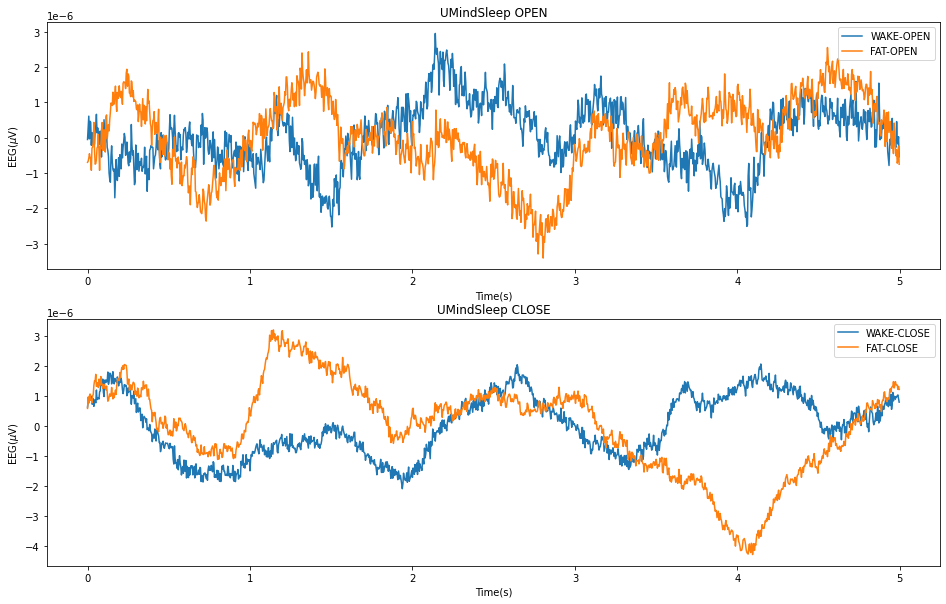

In [ ]:
x=np.arange(0,5,(5/1280))
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16, 10))
ax1.set_title("UMindSleep OPEN")
ax1.plot(x,wkaverageopen,label='WAKE-OPEN')
ax1.plot(x,slaverageopen,label='FAT-OPEN')
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("EEG($\mu$V)")
ax1.legend()
ax2.set_title("UMindSleep CLOSE")

ax2.plot(x,wkaverageclose,label='WAKE-CLOSE')
ax2.plot(x,slaverageclose,label='FAT-CLOSE')
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("EEG($\mu$V)")
ax2.legend()

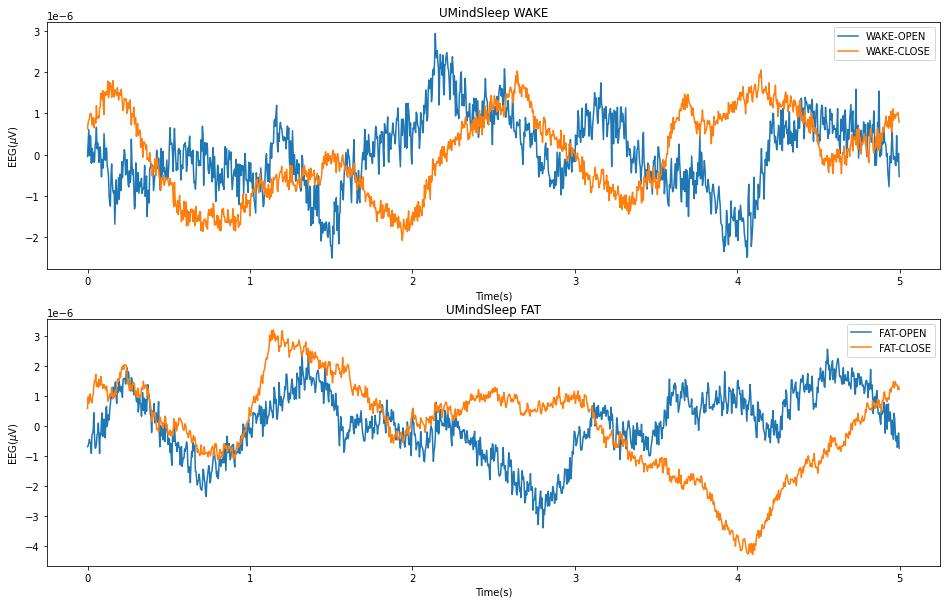

In [ ]:
x=np.arange(0,5,(5/1280))
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16, 10))
ax1.set_title("UMindSleep WAKE")
ax1.plot(x,wkaverageopen,label='WAKE-OPEN')
ax1.plot(x,wkaverageclose,label='WAKE-CLOSE')
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("EEG($\mu$V)")
ax1.legend()

ax2.set_title("UMindSleep FAT")
ax2.plot(x,slaverageopen,label='FAT-OPEN')
ax2.plot(x,slaverageclose,label='FAT-CLOSE')
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("EEG($\mu$V)")
ax2.legend()

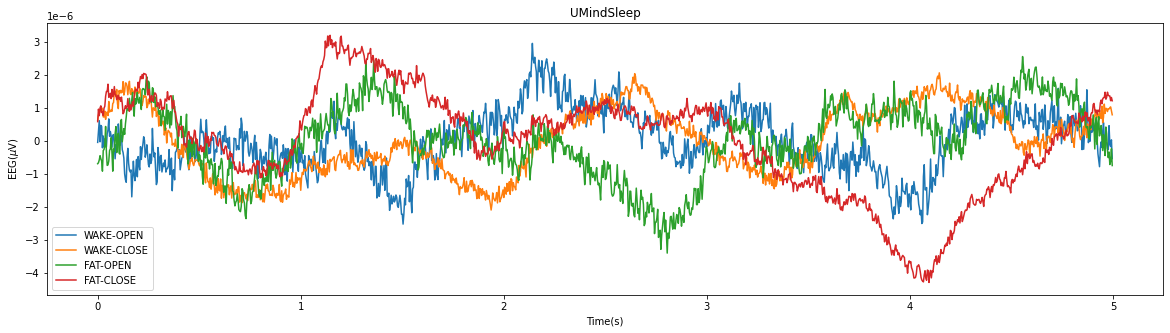

In [ ]:
plt.figure(figsize=(20,5))
plt.title("UMindSleep")
plt.plot(x,wkaverageopen,label='WAKE-OPEN')
plt.plot(x,wkaverageclose,label='WAKE-CLOSE')
plt.plot(x,slaverageopen,label='FAT-OPEN')
plt.plot(x,slaverageclose,label='FAT-CLOSE')
plt.xlabel("Time(s)")
plt.ylabel("EEG($\mu$V)")
plt.legend()

In [ ]:
print(slaverageclose[1088:1110])

[ 1.56250000e-07  3.81944444e-07 -8.09375000e-06 -7.61458333e-06
 -7.62847222e-06 -7.84027778e-06 -7.80902778e-06 -7.50000000e-06
 -7.17708333e-06 -6.77083333e-06 -6.84722222e-06 -7.21180556e-06
 -7.04861111e-06 -6.82638889e-06 -6.46527778e-06 -6.45833333e-06
 -6.83680556e-06  1.51041667e-06  1.31597222e-06  1.77083333e-06
  2.24305556e-06  1.95138889e-06]


In [ ]:
print(type(str(data_folder+'/'+'fat_'+ID+'_sl_close2_'+i+'.csv')))

TypeError: ignored

In [ ]:
print(np.array(Sp_wk).shape)
print(np.array(KSS).shape)

(432, 15)
(432,)


In [ ]:
Sp=[]
KSS=[]

In [ ]:
num=['04','06','08','09','11','12']

for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
   usr_seg=os.listdir(usr_seg_folder+'_wk')
   for folder in usr_seg:
     if(folder[-4]=='.'):
     #  print(0)
        continue
     data_folder=usr_seg_folder+'_wk'+'/'+folder
     data_file=os.listdir(data_folder)
     if (os.path.exists(data_folder+'/.ipynb_checkpoints')):
       data_file.remove('.ipynb_checkpoints')
     #print(data_file)
     out_feature=data_folder+".csv"#,"w")
     feature=pd.DataFrame()
     for file in data_file:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]

       seg_data=pd.read_csv(data_folder+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       #带阻滤波
       filtered_data=Notch_filter(seg_datanp)
       #FFT
       sig_fft,freq_fft=FFT_ham(filtered_data)
       
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       
       feature=pd.concat([feature,cal_data], axis=0)
       
       Sp.append(res)
       KSS.append(1)
   print(Sp)
   print(KSS)
     #feature.to_csv(out_feature)


[[4.3160087153730207e-07, 5.046696822465795e-08, 3.621064282125762e-08, 3.817903879343487, 1.3937053941232738, 3.4456733561720987, 1.3937054164215001, 11.919171788117552, 11.919171765819325, 29.4679010028211, 32.6512707170149, 8.552145823699862, 1.3937054578087436, 0.7175118020682746, 0.26192387768748077], [2.9258674740523407e-07, 8.23782420224167e-08, 3.6036568541165295e-08, 5.137833908094905, 2.285962436415509, 4.231710031916112, 2.285962462173722, 8.11916228925193, 8.119162263493717, 15.029967183124787, 18.24829074974365, 3.5517478914591987, 2.2859625348274033, 0.43745255963112567, 0.19463460388483894], [6.727893328993294e-06, 5.014364122079678e-08, 4.9143637890087685e-08, 2.7141239795794916, 1.020348581701372, 0.2612467398705798, 1.0203486161564794, 136.90263113475297, 136.90263110029787, 35.052105423639425, 364.16056296885415, 134.1724127964393, 1.0203486503200871, 0.9800572930941058, 0.3684430744687281], [6.5569238628585e-07, 6.058927987194153e-08, 5.360711046409667e-08, 2.531385

In [ ]:
num=['04','06','08','09','11','12']

for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
   usr_seg=os.listdir(usr_seg_folder+'_wk')
   #for folder in usr_seg:
   if 1:
     if(folder[-4]=='.'):
     #  print(0)
        continue
     data_folder=usr_seg_folder+'_wk'+'/'+""
     data_file=os.listdir(data_folder)
     if (os.path.exists(data_folder+'/.ipynb_checkpoints')):
       data_file.remove('.ipynb_checkpoints')
     #print(data_file)
 
     feature=pd.DataFrame()
     for file in data_file:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]

       seg_data=pd.read_csv(data_folder+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       feature=pd.concat([feature,cal_data], axis=0)
       
       Sp.append(res)
       KSS.append(1)
   print(Sp)
   print(KSS)

In [ ]:
from matplotlib.widgets import SpanSelector
num=['04','06','08','09','11','12']
SpWKC=[]
SpWKO=[]
SpSLC=[]
SpSLO=[]
Sp=[]
SpO=[]
SpC=[]
KSSC=[]
KSS=[]
KSSO=[]
for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"
   usr_seg_folder=UMS_path+Usr_folder+'/'+Usr_folder
   #print(usr_seg)

   #calculate fatige state
   
  # usr_seg_sl=os.listdir(usr_seg_folder+'_sl')
  # usr_seg_wk=os.listdir(usr_seg_folder+'_wk')
   #x=[]
   #KSS=[]
   
   data_file_slc=usr_seg_folder+'_sl/'+Usr_folder+'_sl_close2'
   data_file_wkc=usr_seg_folder+'_wk/'+Usr_folder+'_wk_close2'
   data_file_slo=usr_seg_folder+'_sl/'+Usr_folder+'_sl_open1'
   data_file_wko=usr_seg_folder+'_wk/'+Usr_folder+'_wk_open1'

   file_slc=os.listdir(data_file_slc)
   file_wkc=os.listdir(data_file_wkc)
   file_slo=os.listdir(data_file_slo)
   file_wko=os.listdir(data_file_wko)

   if (os.path.exists(data_file_slo+'/.ipynb_checkpoints')):
         file_slo.remove('.ipynb_checkpoints')
   if (os.path.exists(data_file_slc+'/.ipynb_checkpoints')):
         file_slc.remove('.ipynb_checkpoints')
   if (os.path.exists(data_file_wko+'/.ipynb_checkpoints')):
         file_wko.remove('.ipynb_checkpoints')
   if (os.path.exists(data_file_wkc+'/.ipynb_checkpoints')):
         file_wkc.remove('.ipynb_checkpoints')
   print((data_file_slo+'/.ipynb_checkpoints'))
   for file in file_wkc:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]
      
       seg_data=pd.read_csv(data_file_wkc+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       #feature=pd.concat([feature,cal_data], axis=0)
       
       SpWKC.append(res)
       SpC.append(res)
       Sp.append(res)
       KSS.append(1)
       KSSC.append(1)

   for file in file_slc:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]
     
       seg_data=pd.read_csv(data_file_slc+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       #feature=pd.concat([feature,cal_data], axis=0)
       
       SpSLC.append(res)
       SpC.append(res)
       Sp.append(res)
       KSS.append(0)
       KSSC.append(0)
   for file in file_slo:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]
      
       
       seg_data=pd.read_csv(data_file_slo+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       #feature=pd.concat([feature,cal_data], axis=0)
       SpO.append(res)
       SpSLO.append(res)
       Sp.append(res)
       KSS.append(0)
       KSSO.append(0)

   for file in file_wko:
       if(file[-7]=='_'):
         k=-7
         row=file[:k]
       else:
         k=-6
         row=file[:k]
       
       
       seg_data=pd.read_csv(data_file_wko+'/'+file)
       seg_datanp=seg_data["EEG"].to_numpy()
       filtered_data=Notch_filter(seg_datanp)
       sig_fft,freq_fft=FFT_ham(filtered_data)
       eeg_power=np.abs(sig_fft)**2
       delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data,row)
       cal_data,res =Sp_cal(delta, theta, alpha, beta, gamma, fi)
       #feature=pd.concat([feature,cal_data], axis=0)
       SpO.append(res)
       SpWKO.append(res)
       Sp.append(res)
       KSS.append(1)
       KSSO.append(1)

print(SpSLO)
print(SpSLC)
print(SpWKO)
print(SpWKC)
print(KSS)
     #feature.to_csv(out_feature)


/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_04/fat_04_sl/fat_04_sl_open1/.ipynb_checkpoints
/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_06/fat_06_sl/fat_06_sl_open1/.ipynb_checkpoints
/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_08/fat_08_sl/fat_08_sl_open1/.ipynb_checkpoints
/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_09/fat_09_sl/fat_09_sl_open1/.ipynb_checkpoints
/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_11/fat_11_sl/fat_11_sl_open1/.ipynb_checkpoints
/content/drive/MyDrive/UMindSleep/UMS_Calculated/fat_12/fat_12_sl/fat_12_sl_open1/.ipynb_checkpoints
[[3.7879713753319906e-07, 8.400904353250353e-08, 3.2307897862777375e-08, 11.659277957833545, 2.600263374897324, 5.2970075292409975, 2.6002633863753384, 11.724598719263934, 11.724598707785919, 23.884229663821507, 52.571734308848576, 4.509004288170957, 2.600263466111706, 0.3845764672912443, 0.08576864402001261], [5.345203581710091e-07, 4.31325761914521e-08, 1.6937957074337877e-08, 3.7915050284

In [ ]:
x = np.array(Sp)
y = np.array(KSS)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RepeatedKFold
average_acc = 0.0
kf = RepeatedKFold(n_splits=10, n_repeats=2)
acc = np.zeros(20)
index = 0
for train_index, test_index in kf.split(x):
 train_X= x[train_index]
 train_y =y[train_index]
 test_X, test_y = x[test_index], y[test_index]
 regr = make_pipeline(StandardScaler(), SVC())
 regr.fit(train_X, train_y)
 y_pred = regr.predict(test_X)
 print(accuracy_score(test_y, y_pred))
 acc[index] = accuracy_score(test_y, y_pred)
 index = index + 1
print()
print("UMindSleep MIX average_acc:", np.mean(acc), "std_acc:", 
np.std(acc))

0.6379310344827587
0.5862068965517241
0.6551724137931034
0.6551724137931034
0.5862068965517241
0.7543859649122807
0.7017543859649122
0.631578947368421
0.7368421052631579
0.7017543859649122
0.5689655172413793
0.7413793103448276
0.6551724137931034
0.6379310344827587
0.6896551724137931
0.631578947368421
0.7017543859649122
0.5614035087719298
0.7368421052631579
0.631578947368421

UMindSleep MIX average_acc: 0.66016333938294 std_acc: 0.05736573716661946


In [ ]:
print(x.shape)
print(y.shape)

(575, 15)
(575,)


In [ ]:
print(x[train_index])

[[4.31600872e-07 5.04669682e-08 3.62106428e-08 ... 1.39370546e+00
  7.17511802e-01 2.61923878e-01]
 [2.92586747e-07 8.23782420e-08 3.60365685e-08 ... 2.28596253e+00
  4.37452560e-01 1.94634604e-01]
 [6.72789333e-06 5.01436412e-08 4.91436379e-08 ... 1.02034865e+00
  9.80057293e-01 3.68443074e-01]
 ...
 [6.35597050e-07 1.77743936e-08 9.49058345e-09 ... 1.87284522e+00
  5.33946976e-01 3.54455015e-01]
 [2.91488130e-07 2.22582032e-08 5.70822551e-09 ... 3.89932095e+00
  2.56454922e-01 2.36110519e-01]
 [2.02591471e-07 1.00188370e-08 8.04703485e-09 ... 1.24503463e+00
  8.03190533e-01 6.25277076e-01]]


In [ ]:
x=np.array(Sp) 
y=KSS


from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
# x = numpy.transpose(x)
print(x.shape)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
regr = make_pipeline(StandardScaler(), SVC())
regr.fit(x_train, y_train) 
y_pred = regr.predict(x_test)
print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred))

(432, 15)


ValueError: ignored

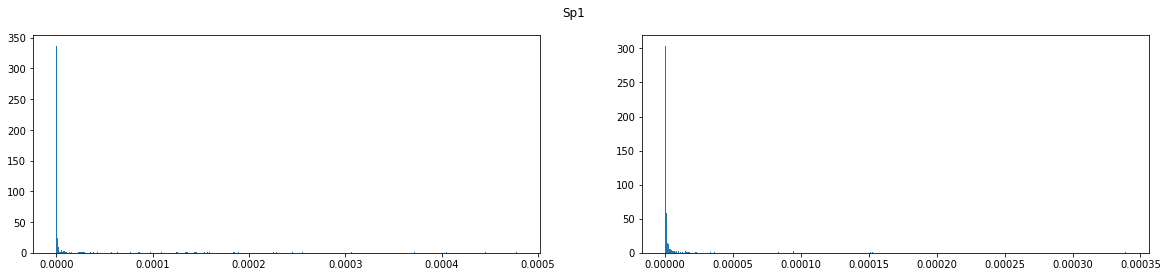

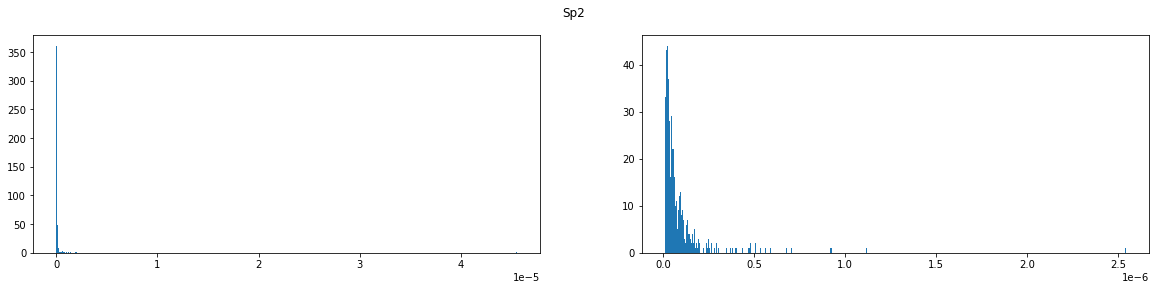

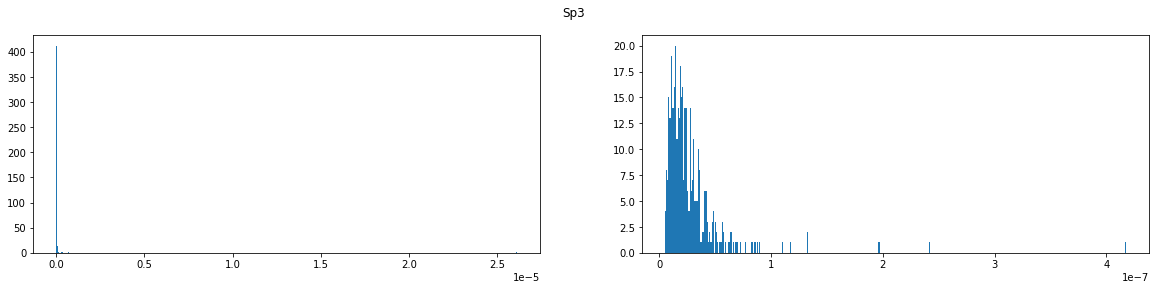

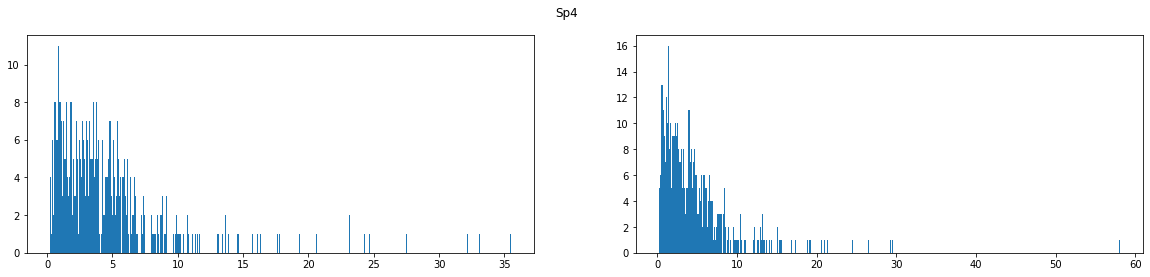

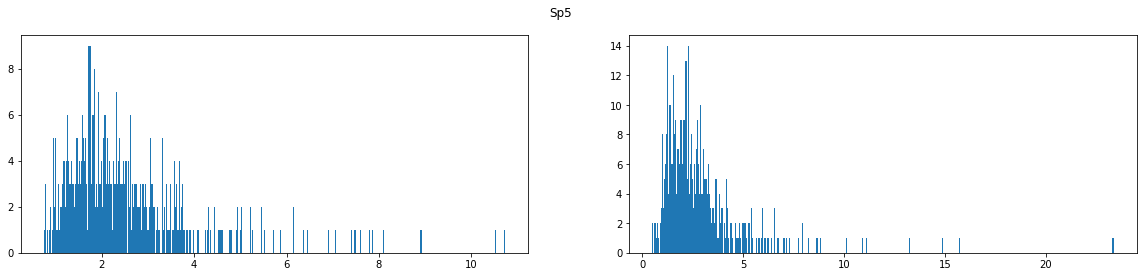

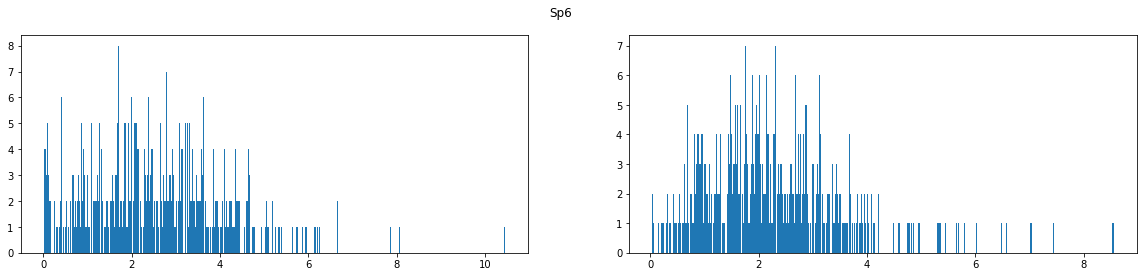

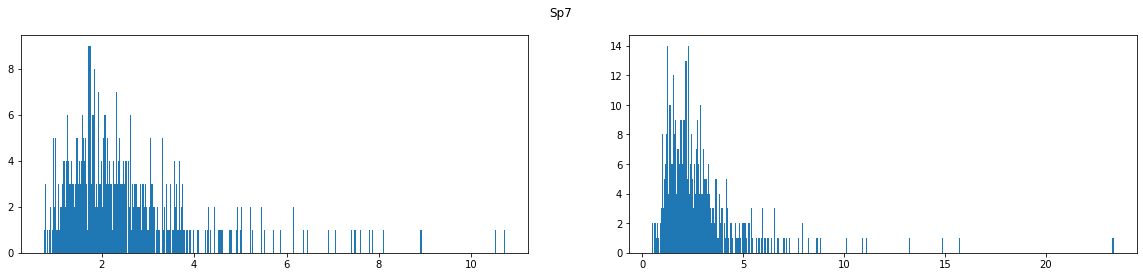

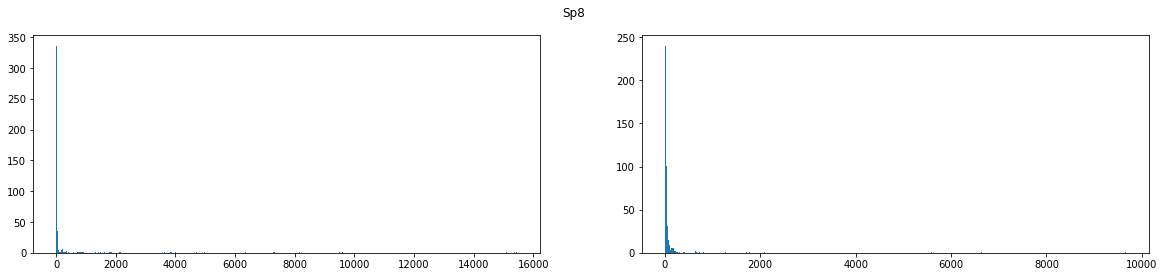

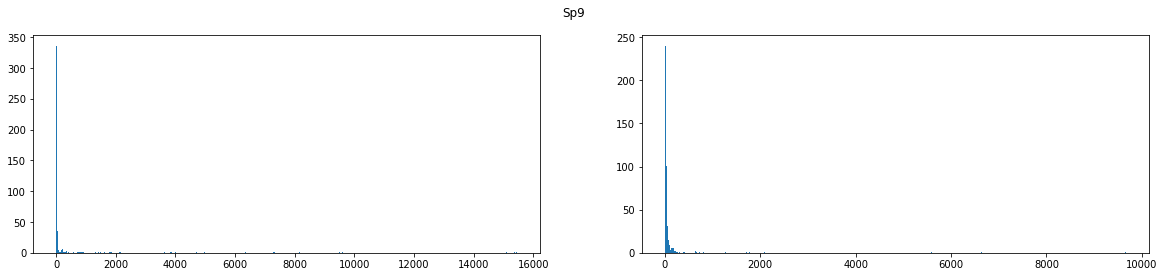

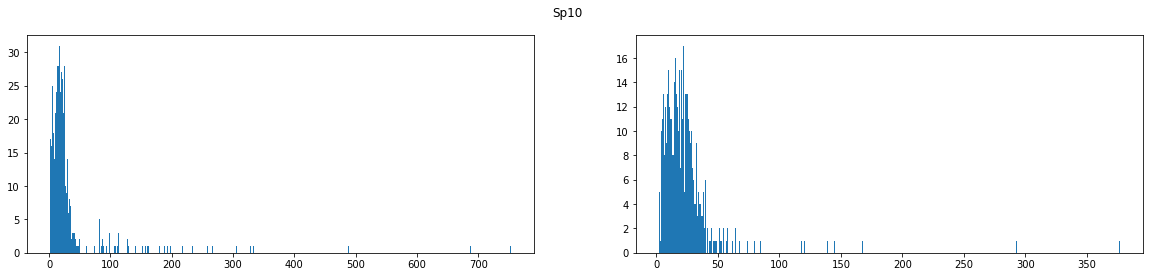

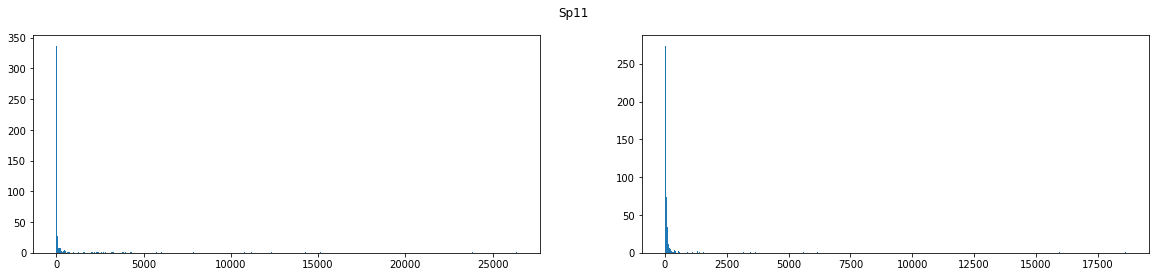

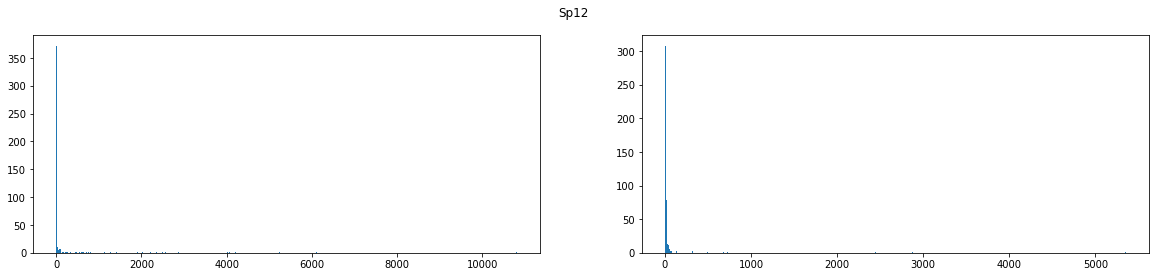

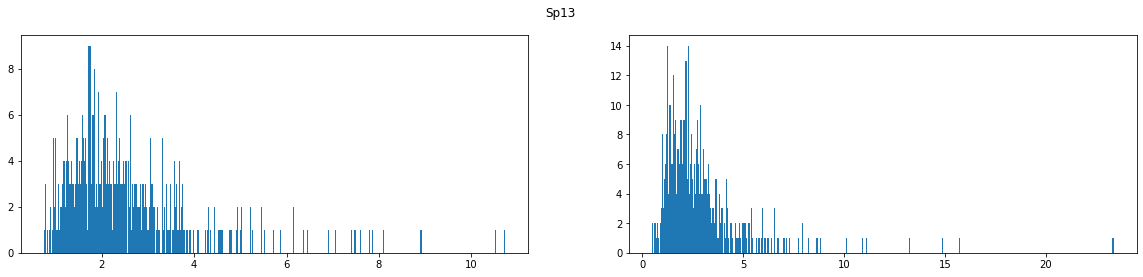

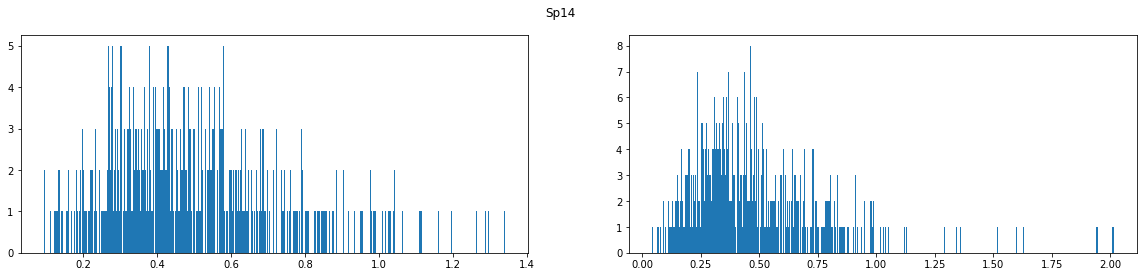

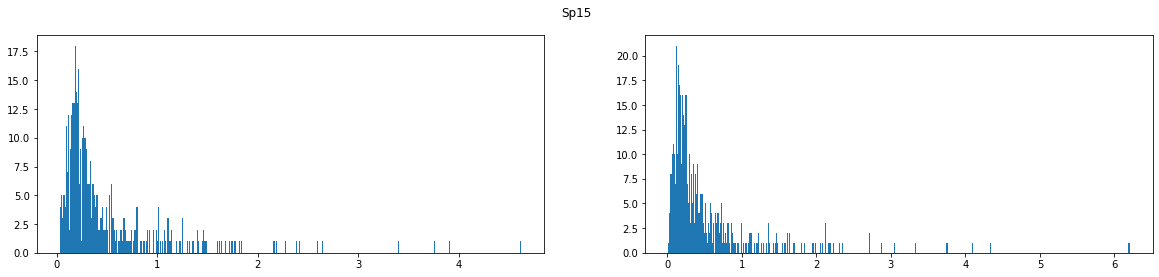

In [ ]:
SPWK=np.transpose(np.array(Sp_wk))
SPSL=np.transpose(np.array(Sp_sl))
for i in range(0,15):
  fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 4))
  t='Sp'+str(i+1)
  fig.suptitle(t)
 # plt.subplot(121)
  #plt.hist(SPWK[i], 432)
  #plt.subplot(122)
  #plt.hist(SPSL[i], 432)
  ax1.hist(SPSL[i],100)
  ax2.hist(SPWK[i],100)
  #print(SP_trans[i])

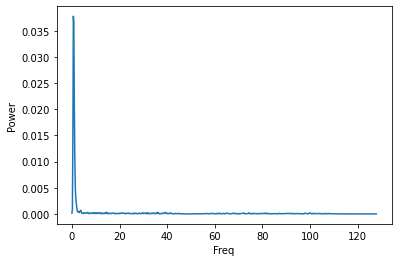

In [ ]:
plt.plot(freq_fft[:640], np.abs(sig_fft[:640]))
plt.xlabel('Freq')
plt.ylabel('Power')
plt.show()

In [ ]:
print(cal_data)

Empty DataFrame
Columns: [delta, theta, alpha, beta, gamma]
Index: []


In [ ]:
num=['04','06','08','09','11','12']
#for i in num:
if 1:
   ID=0
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMindSleep_Data/Segmants5s/"
   usr_seg_folder=UMS_path+Usr_folder+'_5s/'
   usr_seg=os.listdir(usr_seg_folder)
   usr_seg.remove('.ipynb_checkpoints')
   out_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"+Usr_folder
   print(usr_seg)
   for file in usr_seg:
   #if 1:
     #file="fat_04_sl_close2_0.csv"
     out_file=out_path+'/'+Usr_folder+'_'+file[7:9]+'/'
     if(file[-7]=='_'):
       k=-7
       out_folder=file[:k]
     else:
       k=-6
       out_folder=file[:k]
     out_file=out_file+out_folder
     #folder = os.path.exists(out_file)
     #print(out_file)
     #print(folder)
     out=out_file+'/'+file
     seg=open(usr_seg_folder+file,"r")
     seg_data=pd.read_csv(usr_seg_folder+file)
     seg_data.columns = ['point','EEG']
     seg_datanp=seg_data["EEG"].to_numpy()
     filtered_data=Notch_filter(seg_datanp)
     #plt.figure(figsize=(20, 3))
     #plt.plot(filtered_data)
     #plt.figure(figsize=(25, 3))
     #plt.plot(seg_data)
     #print(seg_data.shape)
     sig_fft,freq_fft=FFT_ham(filtered_data)
     eeg_power=np.abs(sig_fft)**2
     
     seg_data["EEG_FFT"]=sig_fft
     seg_data["EEG_SpecPower"]=eeg_power
     delta, theta, alpha, beta, gamma,fi,seg_data=get_channel_mean(eeg_power,seg_data)

     
    # seg_data.to_csv(out)
     #Sp_cal(delta, theta, alpha, beta, gamma, fi, cal_data)
      

    # print(delta)
   #  print(theta)
   #  print(alpha)
    # print(beta)
    # print(gamma)
    # print(seg_data)
    # plt.plot(freq_fft, np.abs(sig_fft))
    # plt.xlabel('Freq')
    # plt.ylabel('Power')
    # plt.show()

In [ ]:
num=['04','06','08','09','11','12']
for i in num:
#if 1:
   ID=i
   Usr_folder='fat_'+ID
   UMS_path="/content/drive/MyDrive/UMindSleep/UMindSleep_Data/"
   usr_seg_folder=UMS_path+Usr_folder+"/"+Usr_folder+"_sl"
   usr_seg=os.listdir(usr_seg_folder)
   if (os.path.exists(usr_seg_folder+'/.ipynb_checkpoints')):
       usr_seg.remove('.ipynb_checkpoints')
   
   out_path="/content/drive/MyDrive/UMindSleep/UMS_Calculated/"+Usr_folder
   print(usr_seg)


['fat_04_sl_20221119-205638_mood.csv', 'fat_04_sl_20221119-205638_gyro.csv', 'fat_04_sl_20221119-205638_spo2.csv', 'fat_04_sl_20221119-205638_sleep_log.csv', 'fat_04_sl_20221119-205638_stage_final.csv', 'fat_04_sl_20221119-205638_part.json', 'fat_04_sl_20221119-205638_feature.bin', 'fat_04_sl_20221119-205638_cmd.log', 'fat_04_sl_20221119-205638_sleep.json', 'fat_04_sl_20221119-205638_device.log', 'fat_04_sl_20221119-205638_stage.csv', 'fat_04_sl.docx', 'fat_04_sl.edf']
['fat_06_sl_20221119-203016_gyro.csv', 'fat_06_sl_20221119-203016_mood.csv', 'fat_06_sl_20221119-203016_feature.bin', 'fat_06_sl_20221119-203016_part.json', 'fat_06_sl_20221119-203016_sleep_log.csv', 'fat_06_sl_20221119-203016_cmd.log', 'fat_06_sl_20221119-203016_spo2.csv', 'fat_06_sl_20221119-203016_sleep.json', 'fat_06_sl_20221119-203016_stage_final.csv', 'fat_06_sl_20221119-203016_stage.csv', 'fat_06_sl_20221119-203016_device.log', 'fat_06_sl.docx', 'fat_06_sl.edf']
['fat_08_sl_20221124-193133_mood.csv', 'fat_08_sl_20